# Cassava Leaf Classification

Out task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With this model, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

Reference: https://www.kaggle.com/c/cassava-leaf-disease-classification/overview

## Import necessary libraries

In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import log_loss

In [2]:
!pip install timm

In [2]:
import timm

In [3]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Moving the dataset to Colab's storage
!cp "/content/drive/My Drive/Colab Notebooks/cassava-leaf-disease-classification.zip" "cassava-leaf-disease-classification.zip"
!unzip "cassava-leaf-disease-classification.zip"

Archive:  cassava-leaf-disease-classification.zip
replace label_num_to_disease_map.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: label_num_to_disease_map.json  
  inflating: sample_submission.csv   
  inflating: test_images/2216849948.jpg  
  inflating: test_tfrecords/ld_test00-1.tfrec  
  inflating: train.csv               
  inflating: train_images/1000015157.jpg  
  inflating: train_images/1000201771.jpg  
  inflating: train_images/100042118.jpg  
  inflating: train_images/1000723321.jpg  
  inflating: train_images/1000812911.jpg  
  inflating: train_images/1000837476.jpg  
  inflating: train_images/1000910826.jpg  
  inflating: train_images/1001320321.jpg  
  inflating: train_images/1001723730.jpg  
  inflating: train_images/1001742395.jpg  
  inflating: train_images/1001749118.jpg  
  inflating: train_images/100204014.jpg  
  inflating: train_images/1002088496.jpg  
  inflating: train_images/1002255315.jpg  
  inflating: train_images/1002394761.jpg  
  inflating: trai

In [4]:
!ls train_images

1000015157.jpg	1764594695.jpg	2518671335.jpg	3299560037.jpg	4081836555.jpg
1000201771.jpg	1764927533.jpg	2519147193.jpg	3299747121.jpg	4082024517.jpg
100042118.jpg	1764971103.jpg	2519456872.jpg	329996274.jpg	4082420465.jpg
1000723321.jpg	1765114818.jpg	2519536403.jpg	3299964343.jpg	4082694328.jpg
1000812911.jpg	1765190680.jpg	2519700384.jpg	3300292911.jpg	4083175669.jpg
1000837476.jpg	176531736.jpg	2520465654.jpg	3300470808.jpg	4083517071.jpg
1000910826.jpg	1765348139.jpg	2520536047.jpg	3300523135.jpg	408355226.jpg
1001320321.jpg	1765374655.jpg	2520567878.jpg	3300885184.jpg	4083589127.jpg
1001723730.jpg	1765947311.jpg	2520575801.jpg	3300973155.jpg	4083644073.jpg
1001742395.jpg	1766436653.jpg	2520781924.jpg	330151252.jpg	4083711449.jpg
1001749118.jpg	1766917625.jpg	2520798009.jpg	3301514895.jpg	4083726805.jpg
100204014.jpg	1766960814.jpg	2520828282.jpg	3301703643.jpg	4083737751.jpg
1002088496.jpg	176734204.jpg	2520831403.jpg	3301808128.jpg	4083768019.jpg
1002255315.jpg	1767778795.jpg	25

In [4]:
# Configuration

CFG = {
    'model_arch_1': 'resnext50_32x4d',
    'model_arch_2': 'tf_efficientnet_b3_ns',
    'fold_num_1': 10,
    'fold_num_2': 5,
    'seed': 719,
    'img_size': 384,
    'epochs': 25,
    'bs_1': 16,
    'bs_2': 8,
    'lr': 1e-3,
    'weight_decay': 1e-5,
    'num_workers': 4,
    'accum_iter': 1, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'target_size': 5
}

In [5]:
train_ids = pd.read_csv('train.csv')
train_ids.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


## Defining helper functions

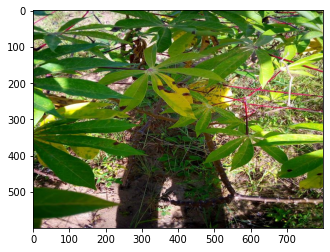

In [6]:
# Helper Functions

def seed_everything(seed):
    '''
    Defines a consistent seed for every needed library and device
    input:
        seed: seed value to be used for all libraries.
    '''

    # Seeding numpy, torch, and cuda
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    '''
    Loading and returning the required image
    input:
        path: The path to the image
    output:
        image: The loaded image found by the given path
    '''
  
    # loading image using cv2 library
    im_bgr = cv2.imread(path)

    # printing the path of the image in case not found
    if im_bgr is None:
      print(path)

    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

img = get_img('train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

## Defining a Dataset class for Cassava Leaf dataset

In [7]:
class CassavaDataset(Dataset):
    '''
    A Data set class for cassva leaf datasets
    input:
        df: a data frame containing the image IDs of the whole dataset.
        data_root: The path of the root file where the data set is located.
        transforms: Tranformations to be applied on the images
        output_label: Specifying weather the lables are inluded or not.
    
    output:
        Dataset: A Dataset object defining a Cassava Leaf dataset
    '''
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
        self.img_list = [img for img in os.listdir(data_root) if img.endswith('.jpg')]
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']

        path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img, self.img_list[idx]

In [11]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 4.1MB/s 
     |████████████████████████████████| 952kB 18.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=53479ff4c1fd97a6a588721b331d0576a715add4e89e26f49501a6ebce24e267
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Data Augumentation

In this stage, we will data augumentation functions to be applied on the images later. This process should yield more informative images that can result in better and faster training.

In [8]:
# importing albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_inference_transforms():
    '''
    Defines dataset tranformations to be applied on the images in later stage
    
    output:
        Aug: a composition of useful tranformations
    '''
    return A.Compose([
            A.RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Model implementation

Here we define a model based on the given archeticture to be used before trainning. Moreovere, we define an ensemble method to combine 2 models to be used later after training.

In [10]:
class CassvaImgClassifier(nn.Module):
    '''
    Implementing a CNN model based on a given archeticure.
    input:
        model_arch: The archeticture in which the model is going to follow.
        n_class: The number of classes the model should predict.
        pretrained: Specifying weather to use a pretrained archeticture or not.
    
    output:
        CassvaImgClassifier: a Module object representing the Cassva Image Classifier.
    '''
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        if (model_arch == CFG['model_arch_2']):
          n_features = self.model.classifier.in_features
          self.model.classifier = nn.Linear(n_features, n_class)
        else:
          n_features = self.model.fc.in_features
          self.model.fc = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
class EnsembleClassifier(nn.Module):
    '''
    Implementing an ensemble classifier based on two powerful CNN models
    input:
        model_arch_1: The first archeticture desired (higher accuracy).
        model_arch_2: The first archeticture desired (lower accuracy).
        n_class: The number of classes the model should predict.
        pretrained: Specifying weather to use a pretrained archeticture or not.
    
    output:
        CassvaImgClassifier: a Module object representing the Cassva Image Classifier.
    '''
    def __init__(self, model_arch_1,model_arch_2, n_class, pretrained=False):
        super().__init__()

        self.model_1 = CassvaImgClassifier(model_arch_1,train_ids.label.nunique())
        self.model_1.load_state_dict(torch.load(PATH + '{}_fold_{}_epoch_{}'.format(model_arch_1, (CFG['fold_num_1']-1), (CFG['epochs'] - 1) ) ))

        self.model_2 = CassvaImgClassifier(model_arch_2,train_ids.label.nunique())
        self.model_2.load_state_dict(torch.load(PATH + '{}_fold_{}_epoch_{}'.format(model_arch_2, (CFG['fold_num_2']-1), (CFG['epochs'] - 1) ) ))
        
    def forward(self, x):
        x1 = self.model_1(x)
        x2 = self.model_2(x)
        return 0.7 * x1 + 0.3 * x2
    
    def load(self, state_dict):
        self.model2.load_state_dict(state_dict)

## Training

In this part, we will implement the training algorithm. First, we'll train a ResNet50 until we reach a deceent validation accuracy. Then, we train an EfficientNet until we reach a better or compaable accuracy. Finally, we combinee both models with different weights based on their performance to constitue more powerful ensemble model

### Criterion

We tried a new approach. That is using Adam at the begging to converge faster. Then, after reaching 89% validations accuracy, we change the criterion to SGD to generalize better.

### Learning Rate

We applied a simple manual scheduling idea. For the ResNet model we moved between learning rates in the range of (1e-4, 1e-6). Mostly from the greater to the lesser, and sometimes we increase it to exit a local minima. For the EfficientNet, we started at 1e-4, then moved to 5e-5 at 89% validation accuracy.

In [12]:
def calc_acc(model, data_loader,criterion):
    '''
    Calculates the accouracy and the loss of the given 
    After being processed on the given dataset.
    input:
        model: The model to pass the data on.
        data_loader: The dataset dsired to predict.
        criterion: The criterion used to train the model in order to calculrate the loss.
    
    output:
        loss: The loss.
        accuracy: The accuracy percentage of the model.
    '''
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0
    
    device = torch.device(CFG['device'])

    for batch_num, (feats, labels) in enumerate(data_loader):
        feats, labels = feats.to(device), labels.to(device)

        outputs = model(feats)
        
        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        
        loss = criterion(outputs, labels.long())
        
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        test_loss.extend([loss.item()]*feats.size()[0])
        del feats
        del labels

    model.train()
    return np.mean(test_loss), accuracy/total

In [13]:
def train_cassava(model_arch,folds,batch_size):

  '''
  Train the given model architicure on Cassava Leaf Disease Classification
  using cross validation with the given folds number, and implementing the
  preproposed configuration in the training process. Finally, a fully
  trained model is saved in the cloud for easy retrieval in future.

  input:
      model_arch: The model architicture that is going to be trained.
      folds: The number of folds to follow in the cross validation process.
  
  '''

  torch.cuda.empty_cache()

  seed_everything(CFG['seed'])

  # Using StratifiedKFold to make sure that every fold is a good representative of the data
  folds = StratifiedKFold(n_splits=folds).split(np.arange(train_ids.shape[0]), train_ids.label.values)

  device = torch.device(CFG['device'])

  model = CassvaImgClassifier(model_arch, train_ids.label.nunique()).to(device)
  model.load_state_dict(torch.load(PATH + '{}_fold_{}_epoch_{}'.format(model_arch, 2, 6 ) )) ##
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], momentum=0.9)
  # optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay, amsgrad=False)



  for fold, (trn_idx, val_idx) in enumerate(folds):

      if fold < 3:
        continue
        
      if fold > 3:
          model = CassvaImgClassifier(model_arch,train_ids.label.nunique()).to(device)
          model.load_state_dict(torch.load(PATH + '{}_fold_{}_epoch_{}'.format(model_arch, (fold-1), (CFG['epochs'] - 1) ) ))
          model.train()
          CFG['lr'] = 1e-4

      print('Inference fold {} started'.format(fold))

      train_ = train_ids.loc[trn_idx,:].reset_index(drop=True)
      train_ds = CassavaDataset(train_, 'train_images', transforms=get_inference_transforms(), output_label=True)

      valid_ = train_ids.loc[val_idx,:].reset_index(drop=True)
      valid_ds = CassavaDataset(valid_, 'train_images', transforms=get_inference_transforms(), output_label=True)
      
      test = pd.DataFrame()
      test['image_id'] = list(os.listdir('test_images'))
      test_ds = CassavaDataset(test, 'test_images', transforms=get_inference_transforms(), output_label=False)

      train_loader = torch.utils.data.DataLoader(
          train_ds, 
          batch_size=batch_size,
          num_workers=CFG['num_workers'],
          shuffle=False,
          pin_memory=False,
      )

      val_loader = torch.utils.data.DataLoader(
          valid_ds, 
          batch_size=batch_size,
          num_workers=CFG['num_workers'],
          shuffle=False,
          pin_memory=False,
      )
      
      tst_loader = torch.utils.data.DataLoader(
          test_ds,  
          batch_size=batch_size,
          num_workers=CFG['num_workers'],
          shuffle=False,
          pin_memory=False,
      )
      
      val_preds = []
      tst_preds = []
      val_acc = 0
      
      #for epoch in range(CFG['epochs']-3):
      for epoch in range(CFG['epochs']):
        
        if (epoch > 0):
          model = CassvaImgClassifier(model_arch,train_ids.label.nunique()).to(device)
          model.load_state_dict(torch.load(PATH + '{}_fold_{}_epoch_{}'.format(model_arch, fold, (epoch-1) ) ))
          model.train()
        
        if (val_acc <= 89 or folds > 2):
          CFG['lr'] = 5e-5
          optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], amsgrad=False)
        else:
          optimizer = torch.optim.SGD(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], momentum=0.9)
      
        avg_loss = 0.0

        for batch_num, (feats, labels) in enumerate(train_loader):
            feats, labels = feats.to(device), labels.to(device)
            
            optimizer.zero_grad()
            # input_batch = feats.unsqueeze(0)
            outputs = model(feats)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()

            if batch_num % 100 == 99:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        

        val_loss, val_acc = calc_acc(model, val_loader,criterion)
        train_loss, train_acc = calc_acc(model, train_loader, criterion)
        
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
              format(train_loss, train_acc, val_loss, val_acc))
        
        torch.save(model.state_dict(), PATH + '{}_fold_{}_epoch_{}'.format(model_arch, fold, epoch) )

        del model

In [ ]:
# Training ResNet50
train_cassava(CFG['model_arch_1'],CFG['fold_num_1'],CFG['bs_1'])

In [ ]:
# Training EfficientNet
train_cassava(CFG['model_arch_2'],CFG['fold_num_2'],CFG['bs_2'])

In [14]:
device = torch.device(CFG['device'])

res_model = CassvaImgClassifier(CFG['model_arch_1'],train_ids.label.nunique()).to(device)
res_model.load_state_dict(torch.load(PATH + '{}_fold_{}_epoch_{}'.format(CFG['model_arch_1'], (CFG['fold_num_1'] - 1) , (CFG['epochs'] - 1) ) ))

eff_model = CassvaImgClassifier(CFG['model_arch_2'],train_ids.label.nunique()).to(device)
eff_model.load_state_dict(torch.load(PATH + '{}_fold_{}_epoch_{}'.format(CFG['model_arch_2'], (CFG['fold_num_2'] - 1) , (CFG['epochs'] - 1) ) ))

theGreatModel = EnsembleClassifier(CFG['model_arch_1'], CFG['model_arch_2'],train_ids.label.nunique()).to(device)

criterion = nn.CrossEntropyLoss()

# Checking the accuracy of the models after training
folds = StratifiedKFold(n_splits=10).split(np.arange(train_ids.shape[0]), train_ids.label.values)

tst_preds = []

for fold, (trn_idx, val_idx) in enumerate(folds):

  if (fold > 0):
    break

  train_ = train_ids.loc[trn_idx,:].reset_index(drop=True)
  train_ds = CassavaDataset(train_, 'train_images', transforms=get_inference_transforms(), output_label=True)
  
  valid_ = train_ids.loc[val_idx,:].reset_index(drop=True)
  valid_ds = CassavaDataset(valid_, 'train_images', transforms=get_inference_transforms(), output_label=True)
  
  train_loader = torch.utils.data.DataLoader(
      train_ds, 
      batch_size=CFG['bs_2'],
      num_workers=CFG['num_workers'],
      shuffle=False,
      pin_memory=False,
  )
  
  val_loader = torch.utils.data.DataLoader(
    valid_ds, 
    batch_size=CFG['bs_2'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=False,
  )

  val_loss_1, val_acc_1 = calc_acc(res_model, val_loader,criterion)
  train_loss_1, train_acc_1 = calc_acc(res_model, train_loader,criterion)
  del res_model
  
  val_loss_2, val_acc_2 = calc_acc(eff_model, val_loader,criterion)
  train_loss_2, train_acc_2 = calc_acc(eff_model, train_loader,criterion)
  del eff_model

  g_loss, g_acc = calc_acc(theGreatModel, val_loader,criterion)
  del theGreatModel

  print('Resnet: Val Loss: {:.4f}\tVal Accuracy: {:.4f}\tTrain Loss: {:.4f}\tTrain Accuracy: {:.4f}'.format(val_loss_1, val_acc_1,train_loss_1, train_acc_1))
  print('Effiecientnet: Val Loss: {:.4f}\tVal Accuracy: {:.4f}\train Loss: {:.4f}\ttrain Accuracy: {:.4f}'.format(val_loss_2, val_acc_2,train_loss_2, train_acc_2))
  print('The Great Model: Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(g_loss, g_acc))

Resnet: Val Loss: 0.3457	Val Accuracy: 0.8822	Train Loss: 0.3245	Train Accuracy: 0.8875
Effiecientnet: Val Loss: 0.5678	Val Accuracy: 0.8248	rain Loss: 0.5432	train Accuracy: 0.8303
The Great Model: Val Loss: 0.3511	Val Accuracy: 0.8743


In [41]:
torch.save(theGreatModel, PATH + 'TheGreatModel')

In [ ]:
60% 40%
Resnet: Val Loss: 0.3513	Val Accuracy: 0.8846	Train Loss: 0.3290	Train Accuracy: 0.8861
Effiecientnet: Val Loss: 0.5439	Val Accuracy: 0.8285	rain Loss: 0.5487	train Accuracy: 0.8290
The Great Model: Val Loss: 0.3549	Val Accuracy: 0.8827

70% 30%
Resnet: Val Loss: 0.3558	Val Accuracy: 0.8776	Train Loss: 0.3306	Train Accuracy: 0.8825
Effiecientnet: Val Loss: 0.5243	Val Accuracy: 0.8243	rain Loss: 0.5484	train Accuracy: 0.8284
The Great Model: Val Loss: 0.3552	Val Accuracy: 0.8799

80% 20%
Resnet: Val Loss: 0.3476	Val Accuracy: 0.8850	Train Loss: 0.3293	Train Accuracy: 0.8834
Effiecientnet: Val Loss: 0.5463	Val Accuracy: 0.8206	rain Loss: 0.5470	train Accuracy: 0.8272
The Great Model: Val Loss: 0.3535	Val Accuracy: 0.8752

In [16]:
test = pd.DataFrame()
test['image_id'] = list(os.listdir('test_images'))
test_ds = CassavaDataset(test, 'test_images', transforms=get_inference_transforms(), output_label=False)

tst_loader = torch.utils.data.DataLoader(
    test_ds,  
    batch_size=CFG['bs_2'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=False,
)

In [20]:
# INFER
theGreatModel = EnsembleClassifier(CFG['model_arch_1'], CFG['model_arch_2'],train_ids.label.nunique()).to(device)
f = open('./submission.csv', 'w')
f.write('image_id,label\n')
idx = 0
device = torch.device(CFG['device'])
with torch.no_grad():
    theGreatModel.eval()
    for i, (image,fns) in enumerate(tst_loader):
        
        image = image.to(device)
        preds = theGreatModel(image)
        preds = preds.argmax(1).squeeze().cpu().numpy()
        print(preds)

        if len(fns)>1:
            for (pred, fn) in zip(preds, fns):
                f.write(fn + ',' + str(pred) + '\n')
                idx += 1
        else:
            f.write(fns[0] + ',' + str(preds) + '\n')
            idx += 1
f.close()

2


In [40]:
while True:pass

KeyboardInterrupt: ignored